
#  Smart Banking Chatbot


In [3]:
# STEP 1: Import Libraries
import os
import torch
import evaluate
import spacy
from datasets import load_dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, classification_report
from spacy.matcher import Matcher
from spacy.lang.en.stop_words import STOP_WORDS
import re
import string
from transformers.trainer_callback import TrainerCallback

# STEP 2: Set Environment and Check Device
os.environ["TRANSFORMERS_NO_TF"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


c:\Users\abdallah\anaconda3\envs\GPU\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0531 22:46:51.659000 64812 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Using device: cuda


#  Dataset Loading & Exploration

In [4]:
# STEP 3: Load the Banking77 Dataset
raw_dataset = load_dataset("banking77")
label_names = raw_dataset["train"].features["label"].names
num_labels = len(label_names)

In [5]:

# Check available splits
print(raw_dataset)  # shows 'train' and 'test' splits


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})


In [8]:


print(f"Number of labels: {num_labels}")
print("Sample label names:", label_names[:12])


Number of labels: 77
Sample label names: ['activate_my_card', 'age_limit', 'apple_pay_or_google_pay', 'atm_support', 'automatic_top_up', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_about_to_expire', 'card_acceptance', 'card_arrival']


In [9]:
example = raw_dataset["train"][0]
print("Text:", example["text"])
print("Label Index:", example["label"])
print("Label Name:", label_names[example["label"]])


Text: I am still waiting on my card?
Label Index: 11
Label Name: card_arrival


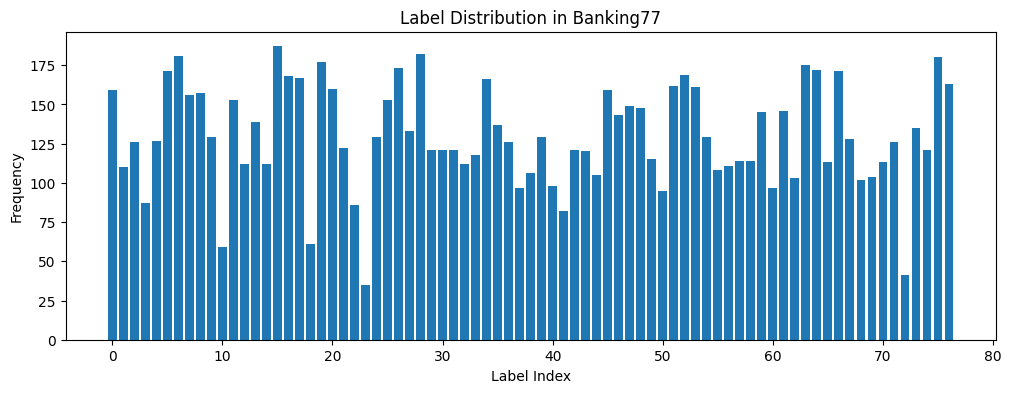

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

# Count label frequencies
label_counts = Counter(example["label"] for example in raw_dataset["train"])

# Convert to list of counts in label order
label_freqs = [label_counts[i] for i in range(num_labels)]

# Plot
plt.figure(figsize=(12, 4))
plt.bar(range(num_labels), label_freqs)
plt.title("Label Distribution in Banking77")
plt.xlabel("Label Index")
plt.ylabel("Frequency")
plt.show()


# Preprocessing

In [3]:
# STEP 4: Preprocess the Text (Normalization + Tokenization)
def clean_text(text):
    text = text.lower()
    text = re.sub(rf"[{string.punctuation}]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in STOP_WORDS]
    return " ".join(tokens)

def preprocess(batch):
    batch["text"] = [clean_text(t) for t in batch["text"]]
    return tokenizer(batch["text"], truncation=True, padding=True)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
dataset = raw_dataset.map(preprocess, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

c:\Users\abdallah\anaconda3\envs\GPU\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [14]:
# STEP 5: Load BERT Classification Model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=num_labels).to(device)

# STEP 6: Define Accuracy Metric
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

c:\Users\abdallah\anaconda3\envs\GPU\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Fine-Tuning

In [5]:
# STEP 7: Set Training Arguments with Progress Bar
training_args = TrainingArguments(
    output_dir="./bert_run_2",
    evaluation_strategy="epoch",
    save_strategy="no",
    num_train_epochs=20,  # Increase epochs for multi-epoch display
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=1000,         # Show log only once per epoch (large number)
    logging_dir="./logs",
    disable_tqdm=False          # Enable progress bar
)

# Custom Callback to Print Epoch Progress
class EpochProgressPrinter(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        print(f"\n✅ Finished Epoch {int(state.epoch)}/{int(args.num_train_epochs)}")

# STEP 8: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EpochProgressPrinter()]  # Add custom callback
)

# STEP 9: Train the Model
print("\nTraining model...")
trainer.train()

# STEP 10: Evaluate on Test Set
metrics = trainer.evaluate()
print("\n=== Final Evaluation ===")
print(metrics)



Training model...


  5%|▍         | 625/12520 [01:04<20:11,  9.82it/s]


✅ Finished Epoch 1/20


                                                   
  5%|▌         | 627/12520 [01:07<1:51:59,  1.77it/s]

{'eval_loss': 2.0168752670288086, 'eval_accuracy': 0.624025974025974, 'eval_runtime': 3.1556, 'eval_samples_per_second': 976.044, 'eval_steps_per_second': 61.161, 'epoch': 1.0}


  8%|▊         | 1002/12520 [01:48<20:52,  9.20it/s] 

{'loss': 2.6187, 'learning_rate': 1.840255591054313e-05, 'epoch': 1.6}


 10%|▉         | 1251/12520 [02:14<19:26,  9.66it/s]


✅ Finished Epoch 2/20


                                                    
 10%|█         | 1254/12520 [02:18<1:54:00,  1.65it/s]

{'eval_loss': 0.9998999834060669, 'eval_accuracy': 0.8090909090909091, 'eval_runtime': 3.319, 'eval_samples_per_second': 927.993, 'eval_steps_per_second': 58.15, 'epoch': 2.0}


 15%|█▍        | 1877/12520 [03:24<20:44,  8.55it/s]  


✅ Finished Epoch 3/20


                                                    
 15%|█▌        | 1880/12520 [03:28<2:24:19,  1.23it/s]

{'eval_loss': 0.6633784174919128, 'eval_accuracy': 0.8496753246753247, 'eval_runtime': 4.1118, 'eval_samples_per_second': 749.066, 'eval_steps_per_second': 46.938, 'epoch': 3.0}


 16%|█▌        | 2002/12520 [03:41<19:16,  9.10it/s]  

{'loss': 0.8254, 'learning_rate': 1.6805111821086264e-05, 'epoch': 3.19}


 20%|█▉        | 2503/12520 [04:35<17:44,  9.41it/s]


✅ Finished Epoch 4/20


                                                    
 20%|██        | 2506/12520 [04:39<2:00:00,  1.39it/s]

{'eval_loss': 0.5542538166046143, 'eval_accuracy': 0.8675324675324675, 'eval_runtime': 3.561, 'eval_samples_per_second': 864.927, 'eval_steps_per_second': 54.198, 'epoch': 4.0}


 24%|██▍       | 3002/12520 [05:30<16:29,  9.62it/s]  

{'loss': 0.3714, 'learning_rate': 1.5207667731629394e-05, 'epoch': 4.79}


 25%|██▍       | 3129/12520 [05:44<16:23,  9.55it/s]


✅ Finished Epoch 5/20


                                                    
 25%|██▌       | 3132/12520 [05:47<1:33:29,  1.67it/s]

{'eval_loss': 0.5200914144515991, 'eval_accuracy': 0.8733766233766234, 'eval_runtime': 3.3032, 'eval_samples_per_second': 932.422, 'eval_steps_per_second': 58.428, 'epoch': 5.0}


 30%|██▉       | 3755/12520 [06:53<15:12,  9.60it/s]  


✅ Finished Epoch 6/20


                                                    
 30%|███       | 3758/12520 [06:56<1:32:43,  1.57it/s]

{'eval_loss': 0.5142098665237427, 'eval_accuracy': 0.8737012987012988, 'eval_runtime': 3.4205, 'eval_samples_per_second': 900.443, 'eval_steps_per_second': 56.424, 'epoch': 6.0}


 32%|███▏      | 4002/12520 [07:22<14:11, 10.00it/s]  

{'loss': 0.2129, 'learning_rate': 1.3610223642172523e-05, 'epoch': 6.39}


 35%|███▍      | 4381/12520 [08:02<14:09,  9.58it/s]


✅ Finished Epoch 7/20


                                                    
 35%|███▌      | 4383/12520 [08:06<2:02:14,  1.11it/s]

{'eval_loss': 0.5199279189109802, 'eval_accuracy': 0.8788961038961038, 'eval_runtime': 3.5027, 'eval_samples_per_second': 879.326, 'eval_steps_per_second': 55.101, 'epoch': 7.0}


 40%|███▉      | 5002/12520 [09:11<13:00,  9.63it/s]  

{'loss': 0.1398, 'learning_rate': 1.2012779552715656e-05, 'epoch': 7.99}


 40%|████      | 5008/12520 [09:12<12:02, 10.40it/s]


✅ Finished Epoch 8/20


                                                    
 40%|████      | 5010/12520 [09:15<1:34:57,  1.32it/s]

{'eval_loss': 0.5474818348884583, 'eval_accuracy': 0.8775974025974026, 'eval_runtime': 3.3598, 'eval_samples_per_second': 916.712, 'eval_steps_per_second': 57.443, 'epoch': 8.0}


 45%|████▍     | 5633/12520 [10:21<11:56,  9.61it/s]  


✅ Finished Epoch 9/20


                                                    
 45%|████▌     | 5636/12520 [10:24<1:17:56,  1.47it/s]

{'eval_loss': 0.5584587454795837, 'eval_accuracy': 0.8821428571428571, 'eval_runtime': 3.4162, 'eval_samples_per_second': 901.594, 'eval_steps_per_second': 56.496, 'epoch': 9.0}


 48%|████▊     | 6001/12520 [11:04<11:45,  9.24it/s]  

{'loss': 0.1023, 'learning_rate': 1.0415335463258786e-05, 'epoch': 9.58}


 50%|████▉     | 6259/12520 [11:31<10:37,  9.82it/s]


✅ Finished Epoch 10/20


                                                    
 50%|█████     | 6262/12520 [11:35<1:05:04,  1.60it/s]

{'eval_loss': 0.6108194589614868, 'eval_accuracy': 0.8701298701298701, 'eval_runtime': 3.6883, 'eval_samples_per_second': 835.063, 'eval_steps_per_second': 52.327, 'epoch': 10.0}


 55%|█████▍    | 6885/12520 [12:41<09:55,  9.46it/s]  


✅ Finished Epoch 11/20


                                                    
 55%|█████▌    | 6888/12520 [12:44<1:03:33,  1.48it/s]

{'eval_loss': 0.5990833640098572, 'eval_accuracy': 0.8785714285714286, 'eval_runtime': 3.4137, 'eval_samples_per_second': 902.248, 'eval_steps_per_second': 56.537, 'epoch': 11.0}


 56%|█████▌    | 7002/12520 [12:56<09:45,  9.42it/s]  

{'loss': 0.0885, 'learning_rate': 8.817891373801917e-06, 'epoch': 11.18}


 60%|█████▉    | 7511/12520 [13:50<08:33,  9.75it/s]


✅ Finished Epoch 12/20


                                                    
 60%|██████    | 7514/12520 [13:54<53:54,  1.55it/s]  

{'eval_loss': 0.6087840795516968, 'eval_accuracy': 0.8772727272727273, 'eval_runtime': 3.3587, 'eval_samples_per_second': 917.012, 'eval_steps_per_second': 57.462, 'epoch': 12.0}


 64%|██████▍   | 8002/12520 [14:45<07:54,  9.52it/s]

{'loss': 0.0808, 'learning_rate': 7.220447284345049e-06, 'epoch': 12.78}


 65%|██████▌   | 8138/12520 [15:00<06:58, 10.46it/s]


✅ Finished Epoch 13/20


                                                    
 65%|██████▌   | 8140/12520 [15:03<55:24,  1.32it/s]

{'eval_loss': 0.6163139343261719, 'eval_accuracy': 0.8798701298701299, 'eval_runtime': 3.4148, 'eval_samples_per_second': 901.948, 'eval_steps_per_second': 56.518, 'epoch': 13.0}


 70%|██████▉   | 8763/12520 [16:09<06:29,  9.65it/s]


✅ Finished Epoch 14/20


                                                    
 70%|███████   | 8766/12520 [16:13<42:57,  1.46it/s]

{'eval_loss': 0.6267595887184143, 'eval_accuracy': 0.8811688311688312, 'eval_runtime': 3.6204, 'eval_samples_per_second': 850.726, 'eval_steps_per_second': 53.308, 'epoch': 14.0}


 72%|███████▏  | 9001/12520 [16:38<06:42,  8.74it/s]

{'loss': 0.0704, 'learning_rate': 5.623003194888179e-06, 'epoch': 14.38}


 75%|███████▌  | 9390/12520 [17:20<04:55, 10.58it/s]


✅ Finished Epoch 15/20


                                                    
 75%|███████▌  | 9392/12520 [17:23<36:57,  1.41it/s]

{'eval_loss': 0.6327310800552368, 'eval_accuracy': 0.8782467532467533, 'eval_runtime': 3.4148, 'eval_samples_per_second': 901.959, 'eval_steps_per_second': 56.519, 'epoch': 15.0}


 80%|███████▉  | 10002/12520 [18:28<04:29,  9.34it/s]

{'loss': 0.0667, 'learning_rate': 4.02555910543131e-06, 'epoch': 15.97}


 80%|███████▉  | 10015/12520 [18:29<04:22,  9.53it/s]


✅ Finished Epoch 16/20


                                                     
 80%|████████  | 10018/12520 [18:33<28:59,  1.44it/s]

{'eval_loss': 0.6288838982582092, 'eval_accuracy': 0.8818181818181818, 'eval_runtime': 3.4479, 'eval_samples_per_second': 893.293, 'eval_steps_per_second': 55.976, 'epoch': 16.0}


 85%|████████▍ | 10641/12520 [19:39<03:14,  9.66it/s]


✅ Finished Epoch 17/20


                                                     
 85%|████████▌ | 10644/12520 [19:43<21:10,  1.48it/s]

{'eval_loss': 0.6330634355545044, 'eval_accuracy': 0.8808441558441559, 'eval_runtime': 3.6102, 'eval_samples_per_second': 853.133, 'eval_steps_per_second': 53.459, 'epoch': 17.0}


 88%|████████▊ | 11001/12520 [20:20<02:39,  9.52it/s]

{'loss': 0.058, 'learning_rate': 2.428115015974441e-06, 'epoch': 17.57}


 90%|████████▉ | 11267/12520 [20:49<02:11,  9.56it/s]


✅ Finished Epoch 18/20


                                                     
 90%|█████████ | 11270/12520 [20:52<13:47,  1.51it/s]

{'eval_loss': 0.629501223564148, 'eval_accuracy': 0.8821428571428571, 'eval_runtime': 3.4266, 'eval_samples_per_second': 898.862, 'eval_steps_per_second': 56.325, 'epoch': 18.0}


 95%|█████████▍| 11893/12520 [21:58<01:03,  9.83it/s]


✅ Finished Epoch 19/20


                                                     
 95%|█████████▌| 11896/12520 [22:02<06:24,  1.62it/s]

{'eval_loss': 0.6290965676307678, 'eval_accuracy': 0.8837662337662338, 'eval_runtime': 3.4731, 'eval_samples_per_second': 886.812, 'eval_steps_per_second': 55.57, 'epoch': 19.0}


 96%|█████████▌| 12002/12520 [22:13<00:53,  9.67it/s]

{'loss': 0.0549, 'learning_rate': 8.306709265175719e-07, 'epoch': 19.17}


100%|█████████▉| 12519/12520 [23:07<00:00,  9.14it/s]


✅ Finished Epoch 20/20


                                                     
100%|██████████| 12520/12520 [23:11<00:00,  9.00it/s]


{'eval_loss': 0.6281505823135376, 'eval_accuracy': 0.8808441558441559, 'eval_runtime': 3.3581, 'eval_samples_per_second': 917.172, 'eval_steps_per_second': 57.472, 'epoch': 20.0}
{'train_runtime': 1391.3609, 'train_samples_per_second': 143.787, 'train_steps_per_second': 8.998, 'train_loss': 0.3766544282626801, 'epoch': 20.0}


100%|██████████| 193/193 [00:03<00:00, 59.01it/s]


=== Final Evaluation ===
{'eval_loss': 0.6281505823135376, 'eval_accuracy': 0.8808441558441559, 'eval_runtime': 3.2869, 'eval_samples_per_second': 937.043, 'eval_steps_per_second': 58.717, 'epoch': 20.0}


#  Chatbot System with Intent Inference & Dialogue Management


In [6]:
# STEP 11: Define BankingChatbot Class with Enhanced NER and Dialogue State
nlp = spacy.load("en_core_web_sm")

mock_users = {
    "user1": {
        "name": "Sarah",
        "password": "pass123",
        "balance": "$5,320.75",
        "account_type": "savings",
        "iban": "DE89370400440532013000"
    },
    "user2": {
        "name": "Ali",
        "password": "mysecurepw",
        "balance": "$2,105.60",
        "account_type": "checking",
        "iban": "GB29NWBK60161331926819"
    }
}

INTENT_MAP = {
    "balance_not_updated_after_cheque_or_cash_deposit": "balance",
    "pending_transfer": "balance",
    "atm_support": "atm_location",
    "transfer_not_received": "transfer_money",
    "transfer": "transfer_money",
    "confirm_transfer": "confirm_transfer"
}

BRANCH_INFO = {
    "cairo": {
        "id": "BR001",
        "address": "Main St 101, Downtown, Cairo",
        "hours": "Sun-Thu, 9AM-5PM",
        "is_main": True
    },
    "alex": {
        "id": "BR002",
        "address": "21 Sea Road, Alexandria",
        "hours": "Sun-Thu, 9AM-4PM",
        "is_main": False
    },
    "alamin": {
        "id": "BR003",
        "address": "Palm District, New Alamin",
        "hours": "Sun-Thu, 10AM-6PM",
        "is_main": False
    },
    "upper egypt": {
        "id": "BR004",
        "address": "Riverbank Rd, Aswan",
        "hours": "Sun-Thu, 9AM-3PM",
        "is_main": False
    },
    "sharkia": {
        "id": "BR005",
        "address": "Tanta Rd 9, Zagazig",
        "hours": "Sun-Thu, 9AM-4PM",
        "is_main": False
    }
}

BRANCH_SYNONYMS = {
    "main": "cairo",
    "head": "cairo",
    "downtown": "cairo",
    "alexandria": "alex",
    "al alamein": "alamin",
    "alamein": "alamin",
    "upper": "upper egypt",
    "aswan": "upper egypt",
    "zagazig": "sharkia",
    "sharqia": "sharkia"
}

class BankingChatbot:
    def __init__(self, model, tokenizer, label_names, user_data):
        self.model = model
        self.tokenizer = tokenizer
        self.label_names = label_names
        self.nlp = nlp
        self.user_data = user_data
        self.context = {}
        self.session_entities = []
        self.matcher = Matcher(self.nlp.vocab)
        self.add_patterns()
        self.templates = {
            "balance": "Hello {name}, your {account_type} balance is {balance}.",
            "transfer_money": "Okay, you're transferring {amount} to {recipient}. Please confirm to proceed.",
            "atm_location": "Nearest ATM is 2 blocks away at 5th Avenue.",
            "confirm_transfer": "Transfer confirmed. Transaction complete."
        }

    def add_patterns(self):
        account_pattern = [{"LOWER": {"IN": ["savings", "checking", "account"]}}]
        iban_pattern = [{"TEXT": {"REGEX": "^([A-Z]{2}[0-9]{2}[A-Z0-9]{11,30})$"}}]
        money_pattern = [{"TEXT": {"REGEX": r"^\$?[0-9]+"}}]
        routing_number_pattern = [{"TEXT": {"REGEX": "^[0-9]{9}$"}}]
        txn_id_pattern = [{"TEXT": {"REGEX": "^[A-Z0-9]{10,}$"}}]
        balance_pattern = [{"LOWER": "balance"}]
        self.matcher.add("ACCOUNT_TYPE", [account_pattern])
        self.matcher.add("IBAN", [iban_pattern])
        self.matcher.add("MONEY", [money_pattern])
        self.matcher.add("ROUTING", [routing_number_pattern])
        self.matcher.add("TXN_ID", [txn_id_pattern])
        self.matcher.add("BALANCE", [balance_pattern])

    def extract_entities(self, text):
        doc = self.nlp(text)
        matches = self.matcher(doc)
        entities = [(doc[start:end].text, self.nlp.vocab.strings[match_id]) for match_id, start, end in matches]
        entities += [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ["PERSON", "MONEY"]]
        for token in doc:
            token_text = token.text.lower()
            if token_text in BRANCH_INFO:
                entities.append((token_text, "BRANCH"))
            elif token_text in BRANCH_SYNONYMS:
                entities.append((BRANCH_SYNONYMS[token_text], "BRANCH"))
        self.session_entities.extend(entities)
        return entities

    def get_entity(self, entities, label, default="unknown"):
        for ent, ent_label in entities:
            if ent_label == label:
                return ent
        return default

    def predict_intent(self, text):
        self.model.eval()
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            pred_class = torch.argmax(probs, dim=1).item()
            fine_intent = self.label_names[pred_class]
            general_intent = INTENT_MAP.get(fine_intent, fine_intent)
            confidence = probs[0][pred_class].item()
        if confidence < 0.3:
            text_lower = text.lower()
            if "balance" in text_lower:
                general_intent = "balance"
            elif "atm" in text_lower:
                general_intent = "atm_location"
            elif "transfer" in text_lower:
                general_intent = "transfer_money"
            elif any(branch in text_lower for branch in BRANCH_INFO):
                general_intent = "branch_info"
            elif "branch" in text_lower or "office" in text_lower or "location" in text_lower:
                general_intent = "branch_info"
        return general_intent, confidence

    def generate_response(self, intent, entities, user_id="user1"):
        user = self.user_data.get(user_id, {})
        if intent == "balance":
            if not any(e[1] == "ACCOUNT_TYPE" for e in entities):
                entities.append((user.get("account_type", "account"), "ACCOUNT_TYPE"))
            return self.templates[intent].format(
                name=user.get("name", "User"),
                account_type=user.get("account_type", "account"),
                balance=user.get("balance", "$0")
            )
        elif intent == "transfer_money":
            amount = self.get_entity(entities, "MONEY", "$500")
            recipient = self.get_entity(entities, "PERSON", "recipient")
            self.context["awaiting_recipient"] = True
            return self.templates[intent].format(amount=amount, recipient=recipient)
        elif intent == "confirm_transfer" and self.context.get("awaiting_recipient"):
            self.context["awaiting_recipient"] = False
            return self.templates[intent]
        elif intent == "branch_info":
            branch_name = self.get_entity(entities, "BRANCH", "cairo").lower()
            info = BRANCH_INFO.get(branch_name)
            if info:
                return (
                    f"Branch ID: {info['id']}\n"
                    f"Location: {branch_name.title()} ({'Main Branch' if info['is_main'] else 'Branch'})\n"
                    f"Address: {info['address']}\n"
                    f"Working Hours: {info['hours']}"
                )
            return "Sorry, I couldn’t find that branch information."
        return self.templates.get(intent, f"I understood your intent as '{intent}', but I need more details to help.")

    def process_query(self, user_input, user_id="user1"):
        intent, confidence = self.predict_intent(user_input)
        entities = self.extract_entities(user_input)
        response = self.generate_response(intent, entities, user_id=user_id)
        self.context["last_intent"] = intent
        return {
            "input": user_input,
            "intent": intent,
            "confidence": confidence,
            "entities": entities,
            "response": response
        }

#  Interactive Chat Interface

In [7]:
# STEP 12: Start Interactive Dialogue with the Bot and Login
bot = BankingChatbot(model, tokenizer, label_names, user_data=mock_users)

print("\n=== Welcome to Secure Banking Chatbot ===")
username = input("Username: ")
password = input("Password: ")

if username in mock_users and mock_users[username]["password"] == password:
    print(f"\nHello, {mock_users[username]['name']}! You can start chatting. Type 'exit' to quit.")
    while True:
        user_input = input("You: ")
        if user_input.lower() == "exit":
            print("Bot: Goodbye!")
            break
        result = bot.process_query(user_input, user_id=username)
        print(f"Bot: {result['response']}")
        print(f"→ Intent: {result['intent']} ({result['confidence']:.2f})")
        print(f"→ Entities: {result['entities']}")
else:
    print("Authentication failed. Invalid username or password.")

print(f"\nSession Entities Collected: {bot.session_entities}")




=== Welcome to Secure Banking Chatbot ===

Hello, Sarah! You can start chatting. Type 'exit' to quit.
Bot: Nearest ATM is 2 blocks away at 5th Avenue.
→ Intent: atm_location (0.80)
→ Entities: [('cairo', 'BRANCH')]
Bot: Goodbye!

Session Entities Collected: [('cairo', 'BRANCH')]


#   Model Evaluation

In [8]:
# STEP 13: Classification Report
y_pred = trainer.predict(dataset["test"]).predictions.argmax(axis=1)
y_true = trainer.predict(dataset["test"]).label_ids
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=label_names))

100%|██████████| 193/193 [00:03<00:00, 59.96it/s]


=== Classification Report ===
                                                  precision    recall  f1-score   support

                                activate_my_card       1.00      0.97      0.99        40
                                       age_limit       1.00      0.97      0.99        40
                         apple_pay_or_google_pay       1.00      1.00      1.00        40
                                     atm_support       0.95      0.93      0.94        40
                                automatic_top_up       1.00      0.95      0.97        40
         balance_not_updated_after_bank_transfer       0.71      0.72      0.72        40
balance_not_updated_after_cheque_or_cash_deposit       0.90      0.90      0.90        40
                         beneficiary_not_allowed       0.76      0.95      0.84        40
                                 cancel_transfer       1.00      0.95      0.97        40
                            card_about_to_expire       0.97      0.9